In [ ]:
import pandas as pd

# Load file
df = pd.read_csv('training_dataset.csv')

In [4]:
df.head(5)

,prb_alloc,DRB.UEThpUl,target_prb_ratio
0,12,1355.0,66
1,48,4239.0,66
2,52,4744.0,66
3,91,5562.0,66
4,30,2665.0,66


In [5]:
df.shape

(3600, 3)

In [6]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt
import joblib

In [7]:
X = df[["prb_alloc", "DRB.UEThpUl"]]
# Original labels (e.g., 46 and 66)
y_orig = df["target_prb_ratio"]
unique_targets = sorted(y_orig.unique())
print("Unique target_prb_ratio values:", unique_targets)

if len(unique_targets) != 2:
    raise ValueError(
        f"Expected exactly 2 unique values for target_prb_ratio, got: {unique_targets}"
    )

val_low, val_high = unique_targets[0], unique_targets[1]

# Map original labels -> binary 0/1 for modeling/metrics
label_map = {val_low: 0, val_high: 1}
inv_label_map = {0: val_low, 1: val_high}
y = y_orig.map(label_map)

Unique target_prb_ratio values: [np.int64(46), np.int64(66)]


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Val size:  ", X_val.shape)
print("Test size: ", X_test.shape)

Train size: (2520, 2)
Val size:   (540, 2)
Test size:  (540, 2)


In [9]:
scaler = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["prb_alloc", "DRB.UEThpUl"])
    ]
)

In [10]:
models = {
    "logistic_regression": Pipeline([
        ("scaler", scaler),
        ("model", LogisticRegression(max_iter=1000))
    ]),

    "svm_rbf": Pipeline([
        ("scaler", scaler),
        ("model", SVC(kernel="rbf", C=10, gamma="scale", probability=True))
    ]),

    "random_forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ),

    "gradient_boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
}

In [11]:
val_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.fit(X_train, y_train)
    trained_models[name] = model

    y_val_pred = model.predict(X_val)

    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val)[:, 1]
        roc = roc_auc_score(y_val, y_val_proba)
    else:
        if hasattr(model, "decision_function"):
            scores = model.decision_function(X_val)
            roc = roc_auc_score(y_val, scores)
        else:
            roc = np.nan

    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_val, y_val_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_val, y_val_pred, pos_label=1, zero_division=0)

    val_results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
    }

    print(f"[VAL] Accuracy:  {acc:.4f}")
    print(f"[VAL] Precision: {prec:.4f}")
    print(f"[VAL] Recall:    {rec:.4f}")
    print(f"[VAL] F1-score:  {f1:.4f}")
    print(f"[VAL] ROC-AUC:   {roc:.4f}" if not np.isnan(roc) else "[VAL] ROC-AUC:  N/A")


Training model: logistic_regression
[VAL] Accuracy:  0.6167
[VAL] Precision: 0.6226
[VAL] Recall:    0.5926
[VAL] F1-score:  0.6072
[VAL] ROC-AUC:   0.6836

Training model: svm_rbf
[VAL] Accuracy:  0.7889
[VAL] Precision: 0.7806
[VAL] Recall:    0.8037
[VAL] F1-score:  0.7920
[VAL] ROC-AUC:   0.8951

Training model: random_forest
[VAL] Accuracy:  0.8519
[VAL] Precision: 0.8519
[VAL] Recall:    0.8519
[VAL] F1-score:  0.8519
[VAL] ROC-AUC:   0.9539

Training model: gradient_boosting
[VAL] Accuracy:  0.8685
[VAL] Precision: 0.8783
[VAL] Recall:    0.8556
[VAL] F1-score:  0.8668
[VAL] ROC-AUC:   0.9574


In [12]:
best_model_name = max(val_results, key=lambda m: val_results[m]["f1"])
best_model = trained_models[best_model_name]

best = val_results[best_model_name]
print("\n===== BEST MODEL (Validation) =====")
print(f"Best Model: {best_model_name}")
print(f"Acc={best['accuracy']:.4f}, "
      f"Prec={best['precision']:.4f}, "
      f"Rec={best['recall']:.4f}, "
      f"F1={best['f1']:.4f}, "
      f"ROC={best['roc_auc']:.4f}")



===== BEST MODEL (Validation) =====
Best Model: gradient_boosting
Acc=0.8685, Prec=0.8783, Rec=0.8556, F1=0.8668, ROC=0.9574


In [13]:
y_test_pred = best_model.predict(X_test)

if hasattr(best_model, "predict_proba"):
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    test_roc = roc_auc_score(y_test, y_test_proba)
else:
    if hasattr(best_model, "decision_function"):
        scores_test = best_model.decision_function(X_test)
        test_roc = roc_auc_score(y_test, scores_test)
    else:
        test_roc = np.nan

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, pos_label=1, zero_division=0)
test_rec = recall_score(y_test, y_test_pred, pos_label=1, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, pos_label=1, zero_division=0)

print(f"\n===== TEST performance for best model ({best_model_name}) =====")
print(f"[TEST] Accuracy:  {test_acc:.4f}")
print(f"[TEST] Precision: {test_prec:.4f}")
print(f"[TEST] Recall:    {test_rec:.4f}")
print(f"[TEST] F1-score:  {test_f1:.4f}")
print(f"[TEST] ROC-AUC:   {test_roc:.4f}" if not np.isnan(test_roc) else "[TEST] ROC-AUC:  N/A")

# map predictions back to original labels (46/66)
y_test_pred_labels = pd.Series(y_test_pred).map(inv_label_map)
print("\nSample mapped predictions (original PRB ratios):")
print(y_test_pred_labels.head())


===== TEST performance for best model (gradient_boosting) =====
[TEST] Accuracy:  0.8815
[TEST] Precision: 0.9023
[TEST] Recall:    0.8556
[TEST] F1-score:  0.8783
[TEST] ROC-AUC:   0.9712

Sample mapped predictions (original PRB ratios):
0    66
1    46
2    66
3    46
4    46
dtype: int64


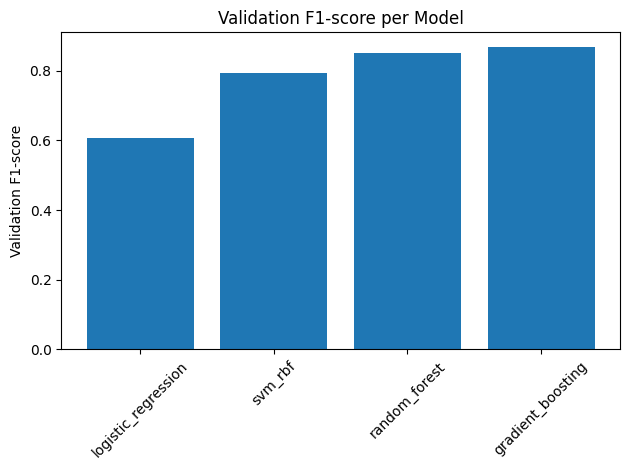

In [14]:
model_names = list(val_results.keys())
f1_values = [val_results[m]["f1"] for m in model_names]

plt.figure()
x_pos = np.arange(len(model_names))
plt.bar(x_pos, f1_values)
plt.xticks(x_pos, model_names, rotation=45)
plt.ylabel("Validation F1-score")
plt.title("Validation F1-score per Model")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

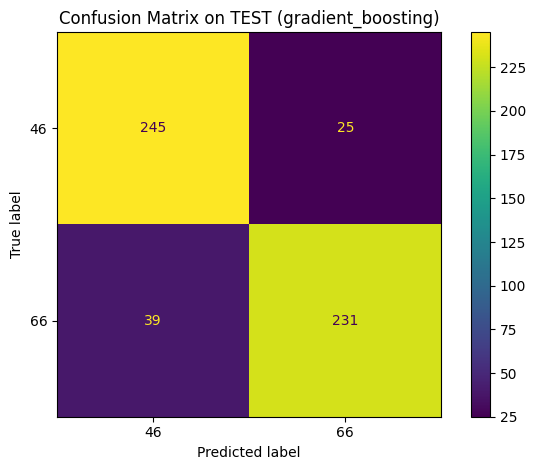

In [15]:
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(val_low), str(val_high)]
)

plt.figure()
disp.plot(values_format="d")
plt.title(f"Confusion Matrix on TEST ({best_model_name})")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

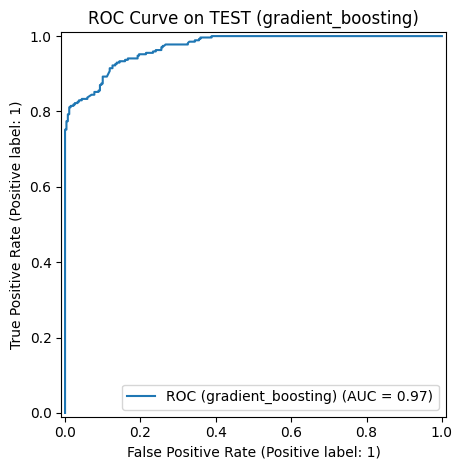

In [16]:
from sklearn.metrics import RocCurveDisplay

plt.figure()
RocCurveDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    name=f"ROC ({best_model_name})"
)
plt.title(f"ROC Curve on TEST ({best_model_name})")
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(best_model, "ml_model.pkl")


['best_prb_ratio_classifier.pkl']

In [18]:
inv_label_map = {
    0: 46,
    1: 66
}
def predict_prb_alloc(prb_alloc, drb_UEThpUl, model=best_model):

    X_new = pd.DataFrame({
        "prb_alloc":   [prb_alloc],
        "DRB.UEThpUl":  [drb_UEThpUl],
    })

    # Use the trained pipeline to predict
    pred = model.predict(X_new)[0]
    prb_ratio = inv_label_map[int(pred)]
    return prb_ratio

In [19]:
prb1 = predict_prb_alloc(
   prb_alloc = 20,
   drb_UEThpUl = 3000
)
print("Predicted PRB allocation:", prb1)


Predicted PRB allocation: 46
